In [9]:
using StateSpaceModels, LinearAlgebra, Plots

# example with missing data

In [18]:
nt = 100
t = LinRange(0.0, 6π, nt)
y = zeros(Float64, (nt,2))
y[:,1] .= sin.(t) + 0.1*randn(77)
y[:,2] .= cos.(t) + 0.1*randn(77)
y[4:4:96,:] .= NaN
model = linear_trend(y)

DimensionMismatch: DimensionMismatch("dimensions must match")

In [16]:
ss = statespace(model)

plot([y y], legend = :topleft, label = "observations", lw = 2, layout = (2, 1), xticks = 0:10:77, color = "black", grid = false)
plot!([ss.filter.a[:, 1] ss.smoother.alpha[:, 1]], label = ["filtered state" "smoothed state"], 
        color = ["indianred" "green"], lw = 2)

DimensionMismatch: DimensionMismatch("dimensions must match")

                  StateSpaceModels.jl v0.2.0                  
 (c) Raphael Saavedra, Guilherme Bodin, and Mario Souto, 2019 
--------------------------------------------------------------
            Starting state-space model estimation.            
    Initiating maximum likelihood estimation with 3 seeds.    
--------------------------------------------------------------
             Seed 0 is aimed at degenerate cases.             
--------------------------------------------------------------
||    seed    |     log-likelihood      |      time (s)     ||
||       0    |        -16183.5265      |          0.08     ||
||       1    |         -1327.2843      |          7.81     ||
||       2    |         -1327.2843      |         16.18     ||
||       3    |         -1327.2843      |         21.87     ||
--------------------------------------------------------------
           Maximum likelihood estimation complete.            
                  Log-likelihood: -1327.2843           

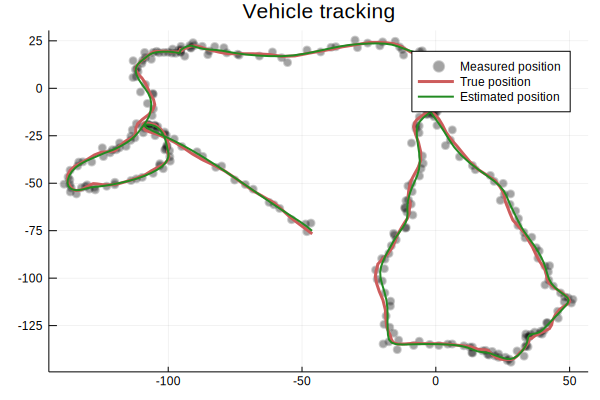

In [17]:
using StateSpaceModels, Distributions, LinearAlgebra, Plots, Random

# Number of observations
n = 300
# State dimension (2d position + 2d speed)
m = 4
# Measurements dimension (2d noisy position)
p = 2
# Control dimension (2d acceleration)
q = 2

# Damping ratio
ρ = .05
# Time delta
Δ = 1.

# State transition matrix
T = kron(Matrix{Float64}(I, p, p), [1. (1. - ρ * Δ / 2.) * Δ; 0. (1. - ρ * Δ)])
# Input matrix
R = kron(Matrix{Float64}(I, p, p), [.5 * Δ^2.; Δ])
# Output (measurement) matrix
Z = kron(Matrix{Float64}(I, p, p), [1. 0])

# Generate random actuators
Q = .5 * Matrix{Float64}(I, q, q)
η = MvNormal(zeros(q), Q)

# Generate random measurement noise
H = 2. * Matrix{Float64}(I, p, p)
ε = MvNormal(zeros(p), H)

# Simulate vehicle trajectory
α = zeros(n + 1, m)
y = zeros(n, p)
for t in 1:n
    y[t, :] = Z * α[t, :] + rand(ε)
    α[t + 1, :] = T * α[t, :] + R * rand(η)  
end
α = α[1:n, :]

# User defined model
model = StateSpaceModel(y, Z, T, R)

# Estimate vehicle speed and position
ss = statespace(model)

plot(y[:, 1], y[:, 2], label="Measured position", line=:scatter, lw=2, markeralpha=0.2, color=:black, title="Vehicle tracking")
plot!(α[:, 1], α[:, 3], label="True position", lw=3, color=:indianred)
plot!(ss.smoother.alpha[:, 1], ss.smoother.alpha[:, 3], label="Estimated position", lw=2, color=:forestgreen)